In [3]:
import pandas as pd
import numpy as np
import seaborn as sns

In [4]:
sns.set(rc={"figure.figsize": (10,7)})

In [5]:
events_data = pd.read_csv("https://stepik.org/media/attachments/course/4852/event_data_train.zip")
submissions_data = pd.read_csv("https://stepik.org/media/attachments/course/4852/submissions_data_train.zip")

In [6]:
events_data["datetime"] = pd.to_datetime(events_data.timestamp, unit='s')
submissions_data["datetime"] = pd.to_datetime(submissions_data.timestamp, unit='s')

In [7]:
submissions_data

,step_id,timestamp,submission_status,user_id,datetime
0,31971,1434349275,correct,15853,2015-06-15 06:21:15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49
3,31972,1478852164,correct,15853,2016-11-11 08:16:04
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03
...,...,...,...,...,...
509099,120745,1501946959,wrong,2615,2017-08-05 15:29:19
509100,120745,1503059927,correct,13177,2017-08-18 12:38:47
509101,120745,1506348153,wrong,15253,2017-09-25 14:02:33
509102,120745,1523035316,wrong,1424,2018-04-06 17:21:56


In [8]:
users_scores = submissions_data.pivot_table(index="user_id",
                                            columns="submission_status",
                                            values="step_id",
                                            aggfunc='count',
                                            fill_value=0).reset_index()

In [9]:
users_scores.sort_values('correct', ascending=False)

submission_status,user_id,correct,wrong
439,1046,421,513
2099,5552,186,93
6415,17135,168,177
2344,6183,142,65
3208,8461,135,42
...,...,...,...
551,1321,0,2
9778,26349,0,1
3559,9422,0,1
5014,13408,0,2


In [10]:
# теперь надо понять активность пользователей на курсе. Постараемся найти промежуток времени,
# при котором пользователя можно считать покинувшим курс. Для начала определим для активности.

events_data["day"] = events_data.datetime.dt.date

# Таким образом мы нашли каждый день, когда пользователь был на курсе (без повторений)
gap_data = events_data[["user_id", "day", "timestamp"]].drop_duplicates(subset=["user_id", "day"])\
    .groupby("user_id")["timestamp"]\
    .apply(list)\
    .apply(np.diff).values

In [11]:
gap_data = pd.Series(np.concatenate(gap_data, axis = 0))

# Переведем секунды в дни

gap_data = gap_data / (24 * 60 * 60)

59.760440972222156

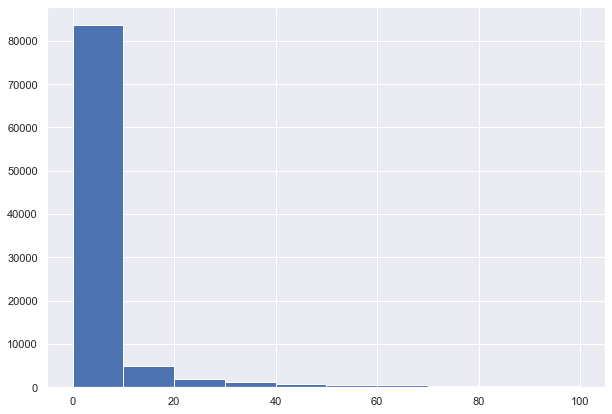

In [12]:
gap_data[gap_data < 100].hist()

# Посчитаем 90% процентиль. Т.о. мы видим, что только 10% пользователей возвращается на курс после 18 дневного перерыва.
# А всего 5% процентов возвращается после двухмесячного перерыва. Раз у нас такой большой разрыв между перерывами, то используем
# нечто среднее ~30 дней
gap_data.quantile(0.90)
gap_data.quantile(0.95)

In [65]:
user_events_data = events_data.pivot_table(columns="action", 
                        index="user_id",
                        values='step_id',
                        aggfunc='count',
                        fill_value=0)\
            .reset_index()\
            .sort_values("viewed", ascending=False)


In [14]:
events_data.sort_values('datetime')
submissions_data.sort_values('datetime')

,step_id,timestamp,submission_status,user_id,datetime
37939,32929,1434340944,correct,17632,2015-06-15 04:02:24
37938,32812,1434341039,correct,17632,2015-06-15 04:03:59
39970,32929,1434342105,correct,442,2015-06-15 04:21:45
39968,32812,1434342145,wrong,442,2015-06-15 04:22:25
39969,32812,1434342156,correct,442,2015-06-15 04:22:36
...,...,...,...,...,...
484798,31981,1526769714,correct,19410,2018-05-19 22:41:54
484804,31988,1526769991,correct,19410,2018-05-19 22:46:31
484803,31986,1526770164,correct,19410,2018-05-19 22:49:24
484812,32089,1526770204,correct,19410,2018-05-19 22:50:04


In [56]:
# Теперь разметим пользователей как покинувших или не покинувших курс,
# Надо учесть, если пользователь получил сертификат и не появлялся больше 30 дней на курсе, то покинувшим курс он не считается

now = events_data.sort_values('timestamp').timestamp.tail(1).values
dropout_threshold = gap_data.quantile(0.90) * 24 * 60 * 60 * 2

user_data = events_data.groupby('user_id', as_index=False)\
           .agg(last_timestamp = ('timestamp', 'max'))
user_data['is_gone_user'] = (now - user_data.last_timestamp) > dropout_threshold

In [57]:
user_data

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True
...,...,...,...
19229,26790,1517495987,True
19230,26793,1510225034,True
19231,26794,1512035039,True
19232,26797,1509995096,True


In [63]:
user_data = user_data.merge(users_scores, on='user_id', how='outer').fillna(0)

In [67]:
user_data = user_data.merge(user_events_data, on='user_id', how='outer').fillna(0)

In [72]:
unique_days = events_data.groupby('user_id', as_index=False).day.nunique()
user_data = user_data.merge(unique_days, how='outer')

In [74]:
# Пользователь считается прошедшим, если у него больше 170 баллов

user_data['passed_corse'] = user_data.passed > 170

In [75]:
user_data

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_corse
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False
...,...,...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8,8,1,9,4,False
19230,26793,1510225034,True,0.0,0.0,1,0,1,1,1,False
19231,26794,1512035039,True,33.0,9.0,69,69,34,180,9,False
19232,26797,1509995096,True,2.0,0.0,10,10,2,13,2,False


In [96]:
user_data['is_gone_fin'] = np.logical_or(user_data['passed_corse'] != False, user_data['is_gone_user'] != False)

In [103]:
user_data.query("is_gone_user != False or passed_corse != False")\
         .groupby('passed_corse').count()

1425/(16402+1425)*100

7.993493016211365

In [88]:
user_data.query("is_gone_user == False and passed_corse == False")

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_corse,is_gone_fin
7,11,1526140625,False,0.0,0.0,1,0,1,1,1,False,False
14,24,1524764853,False,0.0,0.0,1,1,0,2,1,False,False
15,25,1524816605,False,1.0,4.0,26,20,10,40,2,False,False
20,32,1524752239,False,3.0,0.0,14,13,4,22,3,False,False
41,57,1525253230,False,15.0,29.0,43,41,17,87,5,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
19140,26659,1526770439,False,0.0,0.0,3,3,0,3,2,False,False
19142,26661,1524570207,False,9.0,7.0,50,41,21,204,14,False,False
19149,26673,1526365733,False,17.0,56.0,48,46,20,173,18,False,False
19170,26708,1526244028,False,0.0,0.0,1,0,1,1,1,False,False


In [97]:
user_data

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_corse,is_gone_fin
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,True
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,True
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,True
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,True
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8,8,1,9,4,False,True
19230,26793,1510225034,True,0.0,0.0,1,0,1,1,1,False,True
19231,26794,1512035039,True,33.0,9.0,69,69,34,180,9,False,True
19232,26797,1509995096,True,2.0,0.0,10,10,2,13,2,False,True


True     0.926848
False    0.073152
Name: is_gone_fin, dtype: float64